In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
from glasbey import create_palette
import napari

palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

s_palette = sns.cubehelix_palette(as_cmap=True)
pal = sns.color_palette("dark")
cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = create_palette(2000)

In [3]:
def plot_napari(viewer: napari.Viewer, df, column):

    df["reflection_z"] = 2.1*df["POSITION_Z"].max() - df["POSITION_Z"]
    df["reflection_x"] = df["POSITION_X"].max() - df["POSITION_X"]
    
    df["is_reflected"] = df["POSITION_X"] > df["POSITION_X"].max() / 2
    
    df["display_x"] = df["reflection_x"]*df["is_reflected"] + df["POSITION_X"]*(~df["is_reflected"])
    df["display_z"] = df["reflection_z"]*df["is_reflected"] + df["POSITION_Z"]*(~df["is_reflected"])
    
    track_id = np.nan_to_num(df[column].unique())
    print(len(track_id))
    color_map = {track: g_palette[i % 2000] for i, track in enumerate(track_id)}
    color = [color_map[track] for track in df[column].fillna(0)]
    
    viewer.add_points(df[["FRAME", "display_x", "POSITION_Y", "display_z"]], name=column, 
                      properties={"spot id": df.index, column: df[column]},
                      face_color=color, size=13)

parsing spots; frame: 269it [00:04, 59.30it/s] 
parsing edges; track: 6419it [01:01, 104.88it/s]


track id -1 corresponds to 0 edgeless spots
final frame: 268


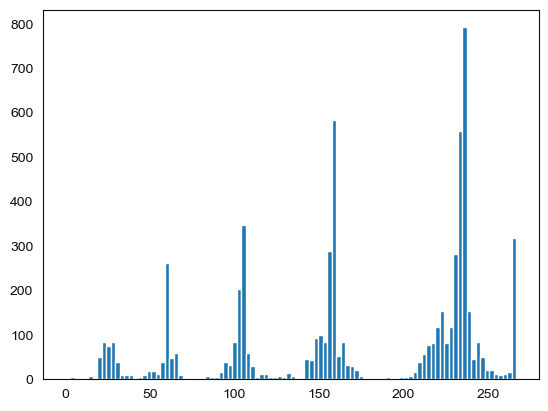

In [4]:
from src.models.new_tracking import process_trackmate_tree
from lxml import etree

source_path = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\2025_02_06")
tracked_points_path = source_path / "trackedspots2.xml"
save_path = source_path / "hybrid3"
save_path.mkdir(exist_ok=True)

tree = etree.parse(str(tracked_points_path))
initial_spots_df, graph = process_trackmate_tree(tree)

plt.hist(initial_spots_df.groupby("linear_track_id")["FRAME"].min(), bins=100)
print(f"final frame: {initial_spots_df['FRAME'].max()}")
plt.show()

In [5]:
# import napari
#
# viewer = napari.Viewer()
# plot_napari(viewer, initial_spots_df, "linear_track_id")
# viewer.theme = 'dark'
# napari.run()

In [5]:
from src.models.new_tracking import interpolate_points

interpolated_spots_df, interpolated_graph = interpolate_points(initial_spots_df, graph)

100%|██████████| 446892/446892 [00:35<00:00, 12666.68it/s]


In [6]:
from src.models.new_tracking import merge_close_tracklets
print(len(interpolated_spots_df.index), len(interpolated_graph.nodes))
merged_spots_df, merged_graph = merge_close_tracklets(interpolated_spots_df, interpolated_graph, max_dis=12)
print(len(merged_spots_df.index), len(merged_graph.nodes))

457604 457604
0


merging tracklets: 6420it [00:01, 3286.51it/s] 


tracklet 372 at time 46
start time 38
end time 46
[0.         0.24486868] [6892 6749]
[1104 178.5992857142857 434.2842857142857 309.06857142857143]
nearest neighbor 6749 at distance 0.24486867784757552
made 330 swaps
456293 456293


In [7]:
from src.models.new_tracking import map_divisions

interphase_dividers = [45, 80, 130, 195, 267]

mapped_graph, test_spots_df = map_divisions(merged_spots_df, merged_graph, interphase_dividers, new_track_cost=25)
# mapped_graph, test_spots_df = map_divisions(interpolated_spots_df, interpolated_graph, interphase_dividers, new_track_cost=25)

mapping divisions between 45 and 80


computing sister distances: 390it [00:00, 840.33it/s]
constructing cost matrix: 390it [00:00, 389935.29it/s]


251 / 390 (max 264) new tracks assigned
mapping divisions between 80 and 130


computing sister distances: 664it [00:01, 545.93it/s]
constructing cost matrix: 664it [00:00, 332024.06it/s]


576 / 664 (max 587) new tracks assigned
mapping divisions between 130 and 195


computing sister distances: 1214it [00:04, 277.93it/s]
constructing cost matrix: 1214it [00:00, 202307.80it/s]


1126 / 1214 (max 1161) new tracks assigned
mapping divisions between 195 and 267


computing sister distances: 2397it [00:14, 169.06it/s]
constructing cost matrix: 2397it [00:00, 133132.23it/s]


2006 / 2397 (max 2033) new tracks assigned


In [8]:
from src.models.new_tracking import process_graph

spots_df = process_graph(merged_spots_df, mapped_graph)
# spots_df = process_graph(interpolated_spots_df, mapped_graph)
print(spots_df[spots_df["FRAME"] == spots_df["FRAME"].max()].groupby("track_id").size().value_counts())
spots_df.to_csv(save_path / "spots.csv")

number of tracklets detected: 12944
tracklet_id
1       -1
2       -1
3       -1
4       -1
5       -1
        ..
12940   -1
12941   -1
12942   -1
12943   -1
12944   -1
Name: parent_id, Length: 12944, dtype: int64
1     665
16    101
8      81
2      79
4      74
14     35
6      34
12     18
10     17
15      6
13      6
7       5
11      2
3       2
9       1
Name: count, dtype: int64


In [43]:
spots_df

,ID,VISIBILITY,RADIUS,QUALITY,POSITION_T,POSITION_X,POSITION_Y,FRAME,POSITION_Z,graph_key,linear_track_id,interpolated,is_swapped,track_id,tracklet_id,parent_id,n_children,n_parents,tracklet_first_parent_id,tracklet_parent_tracklet
0,0,1.0,2.5,1.0,0.0,320.0,419.0,0,167.0,0,1,False,False,251,1,-1,1,0,-1,NaN
242,242,1.0,2.5,1.0,0.0,100.0,536.0,0,95.0,242,239,False,False,141,240,-1,1,0,-1,NaN
241,241,1.0,2.5,1.0,0.0,94.0,490.0,0,94.0,241,238,False,False,153,239,-1,1,0,-1,NaN
240,240,1.0,2.5,1.0,0.0,160.0,50.0,0,185.0,240,237,False,False,335,238,-1,1,0,-1,NaN
239,239,1.0,2.5,1.0,0.0,104.0,610.0,0,104.0,239,236,False,False,131,237,-1,1,0,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520754,520754,1.0,2.5,1.0,0.0,54.0,475.0,246,268.0,520754,4995,False,False,305,8895,515974,0,1,322424,4782.0
520755,520755,1.0,2.5,1.0,0.0,58.0,191.0,246,218.0,520755,1970,False,False,235,5973,515977,0,1,306082,3362.0
520756,520756,1.0,2.5,1.0,0.0,64.0,150.0,246,205.0,520756,1220,False,False,48,7003,515978,0,1,311719,4076.0
520763,520763,1.0,2.5,1.0,0.0,81.0,682.0,246,270.0,520763,4212,False,False,232,7883,515982,0,1,314996,1488.0


In [210]:
# 42072, 42074

# print(spots_df.loc[42078, ["POSITION_X", "POSITION_Y", "POSITION_Z"]])
# print(spots_df.loc[42076, ["POSITION_X", "POSITION_Y", "POSITION_Z"]])
# print(spots_df.loc[39164, ["POSITION_X", "POSITION_Y", "POSITION_Z"]])
# print(spots_df.loc[39162, ["POSITION_X", "POSITION_Y", "POSITION_Z"]])

POSITION_X     55.292683
POSITION_Y    275.862152
POSITION_Z    100.142857
Name: 42078, dtype: object
POSITION_X         55.75
POSITION_Y    272.581134
POSITION_Z    100.142857
Name: 42076, dtype: object
POSITION_X     55.121212
POSITION_Y    279.235729
POSITION_Z    101.937984
Name: 39164, dtype: object
POSITION_X     56.112245
POSITION_Y    276.293862
POSITION_Z    100.437984
Name: 39162, dtype: object


In [11]:
best_spots = spots_df[spots_df["track_id"] > 0].copy()
n_tracklets = best_spots["track_id"].map(best_spots.groupby("track_id")["tracklet_id"].nunique())
best_spots = best_spots[n_tracklets > 1]

In [12]:
import napari
import napari_animation
from PIL import Image as PillowImage

import PIL as P


viewer = napari.Viewer(ndisplay=3)
# plot_napari(viewer, interpolated_spots_df, "interpolated")
# plot_napari(viewer, interpolated_spots_df, "linear_track_id")
# plot_napari(viewer, spots_df, "is_swapped")
# plot_napari(viewer, spots_df, "linear_track_id")
plot_napari(viewer, best_spots, "track_id")
plot_napari(viewer, test_spots_df, "status")
viewer.theme = 'dark'
# viewer._canvas_size = (1800, 1800)



napari.run()


497
3


history of waves what has been observed
need to look at it individually over the entire embryo
how many observed
check the properties


In [41]:
import imageio
from PIL import Image

def make_gif_loop(input_path, output_path):
    """
    Edits the GIF header to loop indefinitely.
    
    Args:
    input_path (str): Path to the input GIF file.
    output_path (str): Path to save the modified GIF file.
    """
    # try:
    # Open the GIF file using PIL
    with Image.open(input_path) as img:
        # Get the frames and duration
        frames = []
        for i in range(1, img.n_frames):
            img.seek(i)
            frames.append(np.array(img.copy()))
            duration = img.info['duration']
                
        # Save the GIF with loop=0 (infinite loop)
        imageio.mimsave(output_path, frames, duration=duration / 1000, loop=0)
        print(f"GIF saved to {output_path} with infinite loop.")


In [44]:
make_gif_loop('tmp_out.gif', 'out.gif')

[(763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640, 3), (763, 640

In [28]:
with P.Image.open('out.gif') as image:
    print(image.info)
    print(image.__dict__)

{'version': b'GIF89a', 'background': 0, 'duration': 40}
{'im': None, 'mode': 'P', '_size': (640, 763), 'palette': <PIL.ImagePalette.ImagePalette object at 0x0000024DC6FB80D0>, 'info': {'version': b'GIF89a', 'background': 0, 'duration': 40}, 'readonly': 1, 'pyaccess': None, '_exif': None, '_min_frame': 0, 'custom_mimetype': None, 'tile': [('gif', (0, 0, 640, 763), 800, (8, False, -1))], 'decoderconfig': (), 'decodermaxblock': 65536, 'fp': <_io.BufferedReader name='out.gif'>, 'filename': 'out.gif', '_exclusive_fp': True, 'global_palette': <PIL.ImagePalette.ImagePalette object at 0x0000024DC70D9D90>, '_fp': <_io.BufferedReader name='out.gif'>, '_GifImageFile__rewind': 781, '_n_frames': None, '_is_animated': None, '_GifImageFile__offset': 800, 'dispose': None, '_GifImageFile__frame': 0, 'disposal_method': 0, '_frame_palette': <PIL.ImagePalette.ImagePalette object at 0x0000024DC70D9D90>, '_frame_transparency': None, 'dispose_extent': (0, 0, 640, 763)}


99 268


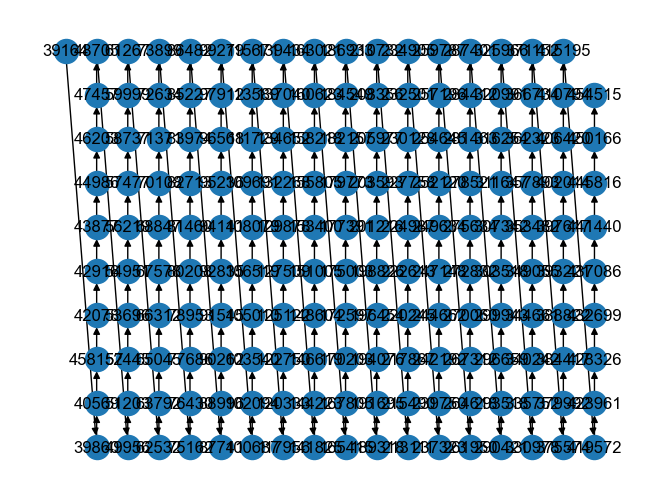

In [223]:
import networkx as nx

df = interpolated_spots_df
gp = interpolated_graph
# tracklet = np.random.choice(df["linear_track_id"].unique())
tracklet = 1014
pts = df[df["linear_track_id"] == tracklet]["graph_key"].values
graph_test = gp.subgraph(pts)

print(df.loc[pts, "FRAME"].min(), df.loc[pts, "FRAME"].max())

nx.draw(graph_test, with_labels=True, pos={k: (v["FRAME"] // 10, v["FRAME"] % 10) for k, v in df[df["graph_key"].isin(graph_test.nodes())].iterrows()})
plt.show()